# Glickman Homework 2

This is my Homework 2 submussion. All of the following code was adapted from the notebook *01_introduction_mnist.ipynb* shown in Session 2.

## Initial Setup

These cells import the necessary libraries, download the MNIST dataset, split the data into training, validation, and test sets, plot examples of the training data, and create dataloader iterables for the training, validation, and test sets. The test set dataloader was not originally included and added for homework.

In [42]:
%matplotlib inline

# Import libraries
import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

In [43]:
# Download MNIST dataset
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [44]:
# Retain 20% of training data for validation purposes
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [45]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


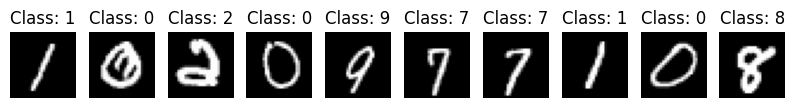

In [46]:
# Plot first 10 training images
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [47]:
# Set bacth size and create dataloaders
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Defining a Nonlinear Classifier

Here, we define the nonlinear classifier. This code was also sourced from the notebook shown in Session 2.

In [48]:
# Define NonLinearClassifier class
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [49]:
# Instantiate a nonlinear classifier and define the loss function and optimizer
nonlinear_model = NonlinearClassifier()
print(nonlinear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)

NonlinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
  )
)


## Defining Helpful Functions

We define functions to train one epoch (every element of the training data has been used for training) and to evaluate the accuracy of our model.

In [50]:
# Define function to train one epoch
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [51]:
# Define function to evaluate the accuracy of the model
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

## Training the Model

We train for the desired number of epochs and evaluate the the model after each one. Then, we visually confirm the results for the first 10 training examples.

In [52]:
%%time

# We train for 10 epochs
epochs = 10
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    print(f"Epoch {j + 1}: training loss: {loss}, accuracy: {acc}")

Epoch 1: training loss: 2.0366195557912192, accuracy: 55.604166666666664
Epoch 2: training loss: 1.1049972432454427, accuracy: 76.89375000000001
Epoch 3: training loss: 0.6599652760028839, accuracy: 83.26249999999999
Epoch 4: training loss: 0.5151577478249868, accuracy: 86.275
Epoch 5: training loss: 0.4458444957733154, accuracy: 87.79791666666667
Epoch 6: training loss: 0.4055573915640513, accuracy: 88.69791666666667
Epoch 7: training loss: 0.3789848700364431, accuracy: 89.43333333333334
Epoch 8: training loss: 0.3597454385360082, accuracy: 89.91875
Epoch 9: training loss: 0.34483984390894573, accuracy: 90.31875000000001
Epoch 10: training loss: 0.33257730054855345, accuracy: 90.60000000000001
CPU times: user 35min 23s, sys: 40.8 s, total: 36min 4s
Wall time: 1min 7s


## Evaluating the Model (Validation Data)

We first view the first 10 training images with their predicted class. Then, we evaluate the model on the validation data.

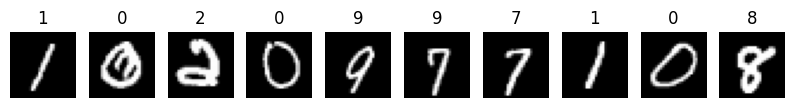

In [53]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
nonlinear_model.eval()
batch = next(iter(train_dataloader))
predictions = nonlinear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

In [54]:
acc_val, loss_val = evaluate(val_dataloader, nonlinear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.3209, validation accuracy: 90.62%


## Checking for Misclassification

We define a function to return the max 10 first misclassifications of a classifier and check them for the nonlinear model. In practice, this process may identify issues with the model, and we may use this information to tune our model in ways which might prevent misclassification.

In [63]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


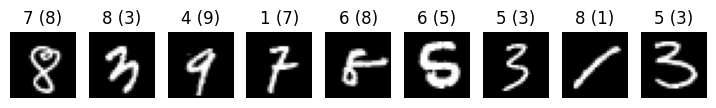

In [64]:
#View max 10 first misclassifications
show_failures(nonlinear_model, val_dataloader)

## Evaluating the Model (Test Data)

Finally, we evaluate the model using the test data to obtain an out-of-sample accuracy metric.

In [65]:
#Evaluate the nonlinear model on the test data
acc_val, loss_val = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.3153, validation accuracy: 90.79%
